## Loading Things

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from utils.datapreparation import my_division_data
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Model
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import cv2

2024-04-22 14:01:13.362741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:01:13.362763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:01:13.363358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 14:01:13.366745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:01:13.816587: W tensorflow/compiler/tf2

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
segmentation_model = models.load_model("/home/grad/ccomp/21/nuneslima/Seismic-Analysis/models/parihaka_best100.keras")


2024-04-22 14:01:15.176976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 14:01:15.302153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 14:01:15.302320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
train_image,train_label, test_image, test_label, val_image, val_label=my_division_data(shape=(992,192), stridetrain=(16,32), strideval=(16,32), stridetest=(16,32))


## Mudar Camada

In [5]:
segmentation_model.summary()

Model: "attunet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 992, 192, 1)]        0         []                            
                                                                                                  
 attunet_down0_0 (Conv2D)    (None, 992, 192, 16)         144       ['input_1[0][0]']             
                                                                                                  
 attunet_down0_0_bn (BatchN  (None, 992, 192, 16)         64        ['attunet_down0_0[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 attunet_down0_0_activation  (None, 992, 192, 16)         0         ['attunet_down0_0_bn[0][

In [6]:
#primeiras
#conv_layer_name="attunet_down0_0"
#conv_layer_name="attunet_down0_4_activation"

#ultimas

#conv_layer_name="attunet_up4_decode_unpool"
#conv_layer_name="attunet_up4_att_activation"
conv_layer_name="attunet_output_activation"


## Funções


In [7]:
# Define a custom model to output both segmentation mask and class activation map
class GradCAMModel(Model):
    def __init__(self, model):
        super(GradCAMModel, self).__init__()
        self.segmentation_model = model
        self.extractor = Model(inputs=model.inputs, outputs=[model.layers[-1].output, model.get_layer(conv_layer_name).output])

    def call(self, x):
        segmentation_mask, feature_map = self.extractor(x)
        return segmentation_mask, feature_map

# Initialize GradCAM model
gradcam_model = GradCAMModel(segmentation_model)

# Define a function to compute gradients with respect to the class activation map
@tf.function
def compute_gradcam(image, class_idx):
    with tf.GradientTape() as tape:
        segmentation_mask, feature_map = gradcam_model(image)
        loss = tf.reduce_mean(segmentation_mask[:, :, :, class_idx])
    
    grads = tape.gradient(loss, feature_map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, feature_map), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    # Convert TensorFlow tensor to numpy array
    return heatmap.numpy()

# Generate heatmap for a sample image
def generate_heatmap(image, class_idx):
    image = image / 255.0  # Normalize image
    
    heatmap = compute_gradcam(image, class_idx)
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_VIRIDIS)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return heatmap


In [8]:
def display_grad_cam(img, heatmap,class_index, alpha=0.5, cmap='viridis'):

    img = img.squeeze(axis=0)
    heatmap = heatmap.squeeze(axis=0)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    viridis_colors = plt.get_cmap(cmap)(np.arange(256))[:, :3]
    viridis_heatmap = viridis_colors[heatmap]

    # Superimpose the heatmap on original grayscale image
    superimposed_img = viridis_heatmap * alpha + np.expand_dims(img, axis=-1)
    superimposed_img = np.clip(superimposed_img, 0, 255)

    # Plot Grad CAM
    plt.subplot(2, 3, class_index + 1)
    plt.imshow(superimposed_img, cmap='gray')
    plt.title(f"Classe: {class_index}")
    plt.axis('off')


In [9]:
def visualize_gradcam(image, num_classes=6):
    image = image / 255.0
    plt.figure(figsize=(15, 10))

    for class_idx in range(num_classes):
        heatmap = compute_gradcam(image, class_idx)
        display_grad_cam(image, heatmap, class_idx)

    plt.tight_layout()
    plt.show()

### Display Functions

In [10]:
def overlay_image_and_mask(image, mask):
    # Verifique se as dimensões das duas matrizes são compatíveis
    if image.shape != mask.shape:
        raise ValueError("As dimensões da imagem e da máscara não correspondem.")

    # Crie uma figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot da imagem original no primeiro subplot
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Imagem Original")
    axes[0].axis('off')

    # Plot da máscara de segmentação no segundo subplot
    axes[1].imshow(mask, cmap='viridis', alpha=0.5)  # Usamos cmap='viridis' para uma melhor visualização da máscara
    axes[1].set_title("Máscara de Segmentação")
    axes[1].axis('off')

    # Mostra a figura
    plt.show()


In [11]:
def overlay_image_and_prediction(image, prediction):
    # Verifique se as dimensões das duas matrizes são compatíveis
    if image.shape[:2] != prediction.shape[1:3]:
        raise ValueError("As dimensões da imagem e da previsão não correspondem.")

    # Crie uma figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot da imagem original no primeiro subplot
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Imagem Original")
    axes[0].axis('off')

    # Obtém a classe com a maior probabilidade para cada pixel
    predicted_classes = np.argmax(prediction[0], axis=-1)

    # Plot da máscara de segmentação resultante da previsão no segundo subplot
    axes[1].imshow(predicted_classes, cmap='viridis', alpha=0.5)  # Usamos cmap='viridis' para uma melhor visualização da máscara
    axes[1].set_title("Máscara de Segmentação (Previsão)")
    axes[1].axis('off')

    # Mostra a figura
    plt.show()

In [12]:
def overlay_true_and_predicted(image, true_mask, predicted_mask):
    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    # Verifique se as dimensões das matrizes são compatíveis
    if image.shape[:2] != true_mask.shape[:2] or image.shape[:2] != predicted_mask.shape[:2]:
        raise ValueError("As dimensões da imagem, máscara verdadeira e máscara prevista não correspondem.")


    accuracy = np.mean(true_mask == predicted_mask) * 100

    # class_colors = [(0, 0, 0),     # black
    #                 (0, 0, 1),   # blue
    #                 (0, 1, 0),   # green
    #                 (1, 0, 0),   # red
    #                 (0.5, 0, 0.5), # purple
    #                 (1, 0.65, 0)  # orange
    #                ]
    class_colors = plt.cm.viridis(np.linspace(0, 1, 6))[:, :3]    # Crie uma lista de rótulos de classe
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]

    # Crie uma figura com três subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot da imagem original no primeiro subplot
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Imagem Original")
    axes[0].axis('off')





    # Plot da máscara de segmentação verdadeira no segundo subplot
    overlay_true_mask = np.zeros(image.shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_true_mask[true_mask == cls] = color
    axes[1].imshow(overlay_true_mask)
    axes[1].set_title("Máscara de Segmentação Verdadeira")
    axes[1].axis('off')


    # Plot da máscara de segmentação prevista no terceiro subplot
    overlay_predicted_mask = np.zeros(image.shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_predicted_mask[predicted_mask == cls] = color
    axes[2].imshow(overlay_predicted_mask)
    axes[2].set_title(f"Máscara de Segmentação Prevista\nAcurácia: {accuracy:.2f}%")
    axes[2].axis('off')
    
    # Adicione uma legenda manual
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for color, label in zip(class_colors, class_labels)]
    axes[0].legend(handles=legend_elements, loc='lower left')

    # Mostra a figura
    plt.show()

## Teste

2024-04-22 14:02:49.259087: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-22 14:02:50.074094: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-04-22 14:02:50.208788: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


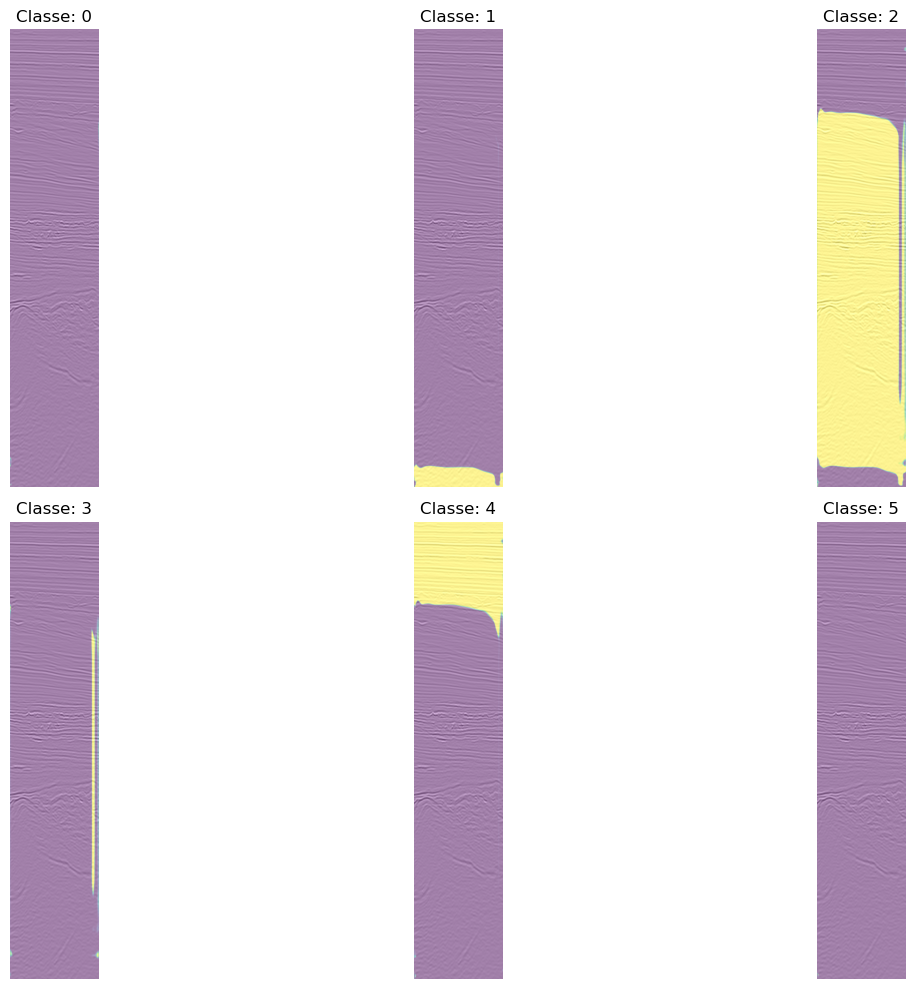

In [13]:
image = train_image[0:1,:,:]
visualize_gradcam(image)

1/1 [==============================] - 0s 103ms/step


/home/grad/ccomp/21/nuneslima/miniconda3/envs/seismic_tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


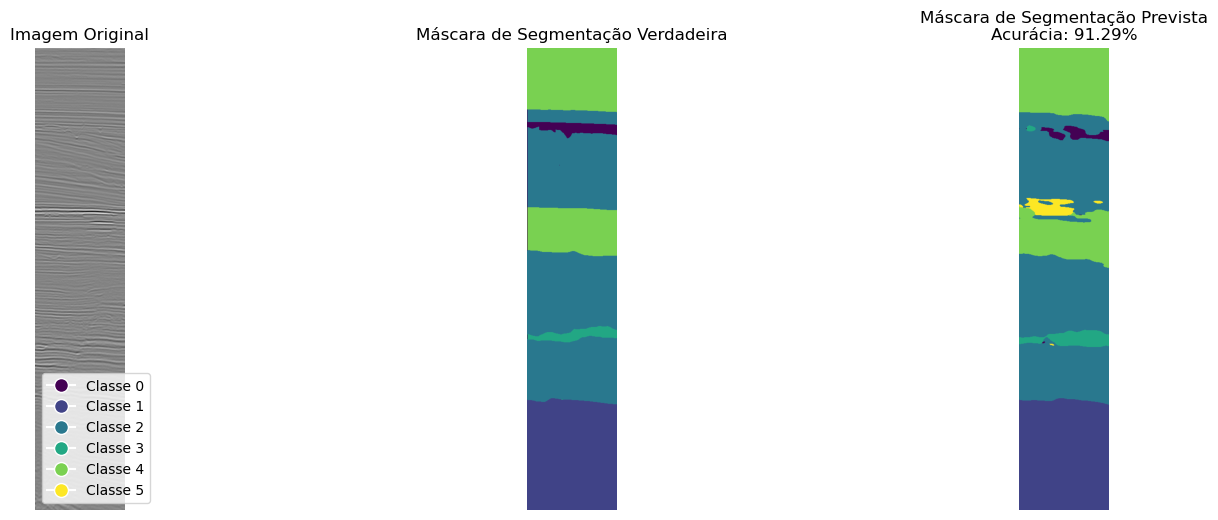

In [14]:
predicted_label=segmentation_model.predict(test_image[:1,:,:])
overlay_true_and_predicted(test_image[0],test_label[0],predicted_label)